# CNN Model Testing Simple
Used to test and feed single audio file inputs to a model. Takes a sliding 5 second long window of the input (stride is configurable), each of which is processed and fed to a corresponding model. These results are then collected and plotted.

Requires saved models from either:
* `cnn_mfcc.ipynb`
* `cnn_mfcc_delta.ipynb`
* `cnn_raw.ipynb`

Requires audio from:
* `user`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy
from scipy.io import wavfile

# SPECIFY AUDIO FILE TO TEST (ex. ***.mp3, ***.wav)

In [2]:
audio_filename = os.path.join("songs", "mr_brightside.mp3") # specify filename/filepath

# Initialize, Get Audio

In [3]:
# Initialize some Parameters
sr = 44100 # sampling rate
song_data = []
ad_data = []
[audio, sr_dc] = librosa.load(audio_filename, sr=sr)

# Load Saved CNN Models

In [4]:
# Define our CNNs

# CNN using only mfccs
class mfcc_CNN(nn.Module):
    def __init__(self):
        super(mfcc_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# CNN using mfccs + delta features
class mfcc_d_CNN(nn.Module):
    def __init__(self):
        super(mfcc_d_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# CNN using only raw data
class raw_CNN(nn.Module):
    def __init__(self):
        super(raw_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1,  32,  kernel_size=10, padding=1)
        self.conv2 = nn.Conv1d(32, 64,  kernel_size=5, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.AvgPool1d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(3527808, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Get model filenames
mfcc_model_name       = os.path.join("models", "cnn_mfcc_model_testing.pth")
mfcc_delta_model_name = os.path.join("models", "cnn_mfcc_delta_model_testing.pth")
raw_model_name        = os.path.join("models", "cnn_raw_model_batch_100_epoch_5.pth")

# Load the state dictionarys
state_dict_1 = torch.load(mfcc_model_name)
state_dict_2 = torch.load(mfcc_delta_model_name)
state_dict_3 = torch.load(raw_model_name)

# Create instances of model
model_mfcc   = mfcc_CNN()
model_mfcc_d = mfcc_d_CNN()
model_raw    = raw_CNN()

# Load the state dictionarys into the models
model_mfcc.load_state_dict(state_dict_1)
model_mfcc_d.load_state_dict(state_dict_2)
model_raw.load_state_dict(state_dict_3)

# Set the models to evaluation mode
model_mfcc.eval()
model_mfcc_d.eval()
model_raw.eval()

raw_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=3527808, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Initialize Windowing Parameters and Functions

In [6]:
# Initialize parameters
seconds_per_window = 5

win_length = 5*sr

win_div = 10

window_stride = win_length//win_div

# Define get window function
def get_window(audio, begin, window_size):
    return audio[(begin):(begin+window_size)]

# Evaluate Audio (MFCC)

In [7]:
# evaluate audio (MFCC)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

audio_eval_mfcc = []
song_confidence_mfcc = []
ad_confidence_mfcc = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model_mfcc(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc.append(output.data[0][0])
    song_confidence_mfcc.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_mfcc)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_mfcc)):
    if(audio_eval_mfcc[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_mfcc = temp_eval

tensor shape: (1, 1, 431, 12)


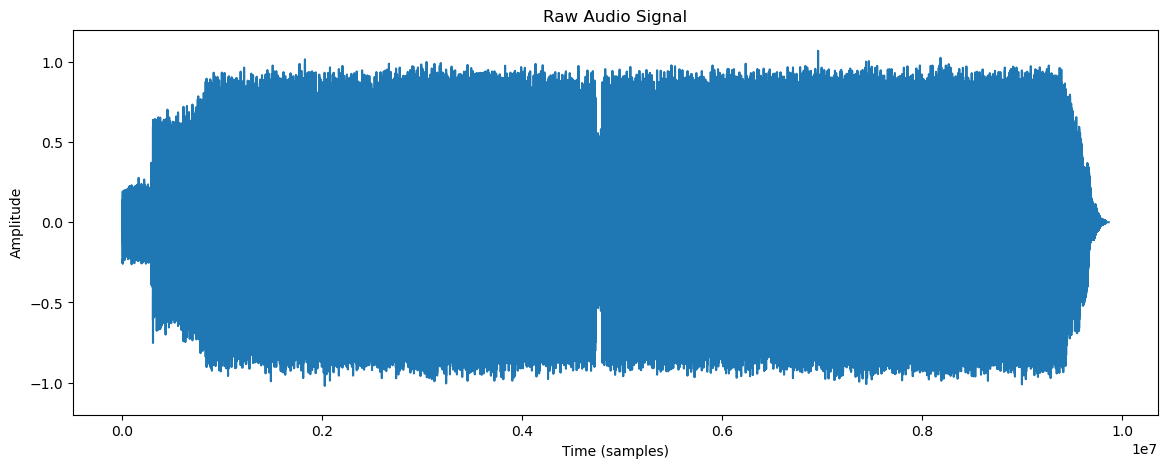

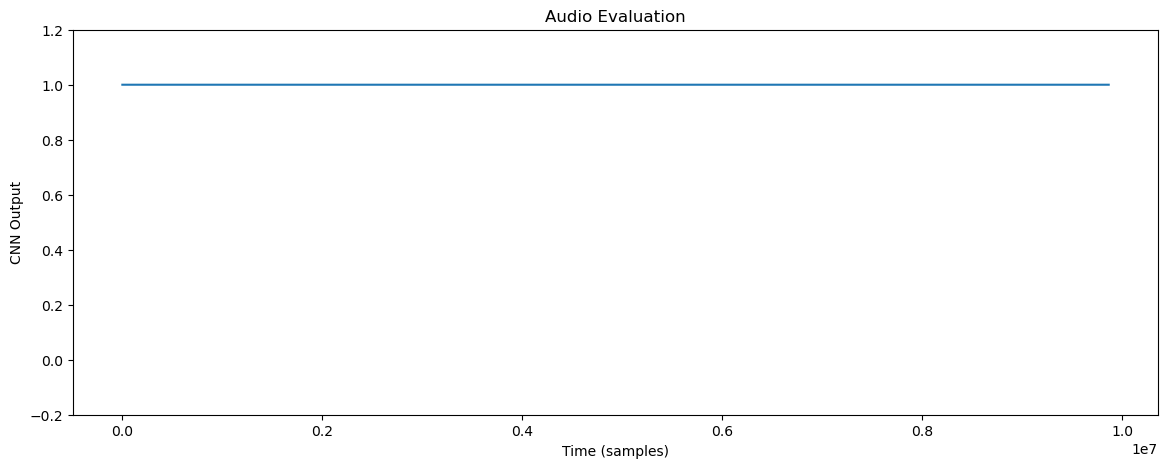

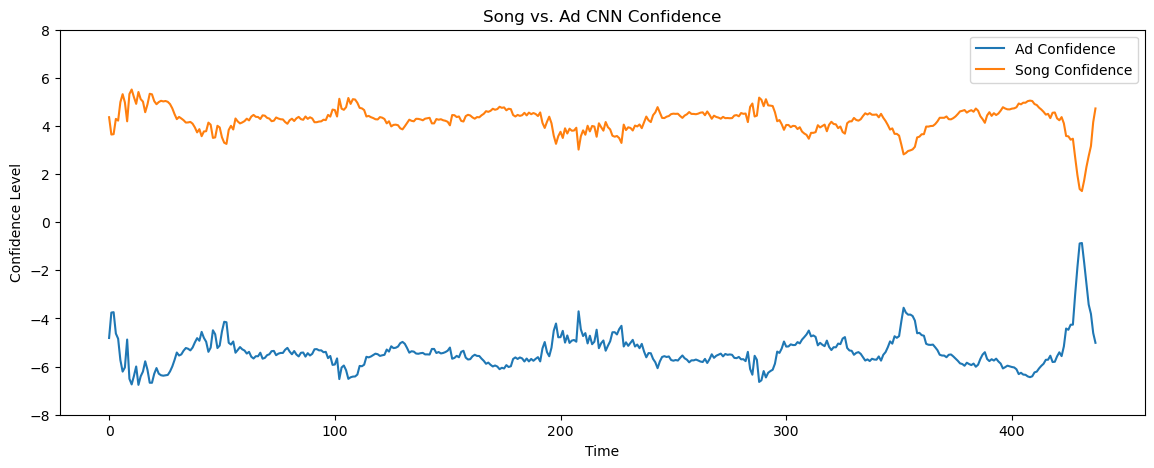

In [8]:
# plot audio (MFCC)
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-1.2, 1.2)
plt.title('Raw Audio Signal')
#plt.savefig(os.path.join("graphics", "mfcc_audio.png"), transparent=True)
plt.show()

# plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Audio Evaluation')
#plt.savefig(os.path.join("graphics", "mfcc_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc, label='Ad Confidence')
plt.plot(song_confidence_mfcc, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-8, 8)
plt.title('Song vs. Ad CNN Confidence')
#plt.savefig(os.path.join("graphics", "mfcc_confidence.png"), transparent=True)
plt.show()

# Evaluate Audio (MFCC + Delta Features)

In [9]:
# evaluate audio (MFCC + delta)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs_d = np.empty((1, 3, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs_d.shape}")

audio_eval_mfcc_d = []
song_confidence_mfcc_d = []
ad_confidence_mfcc_d = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs_d[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_d[0][1] = librosa.feature.delta(mfccs_d[0][0].T).T
    mfccs_d[0][2] = librosa.feature.delta(mfccs_d[0][0].T, order=2).T
    mfccs_tensor = torch.tensor(mfccs_d, dtype=torch.float32)
    output = model_mfcc_d(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc_d.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc_d.append(output.data[0][0])
    song_confidence_mfcc_d.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_mfcc_d)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_mfcc_d)):
    if(audio_eval_mfcc_d[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_mfcc_d = temp_eval

tensor shape: (1, 3, 431, 12)


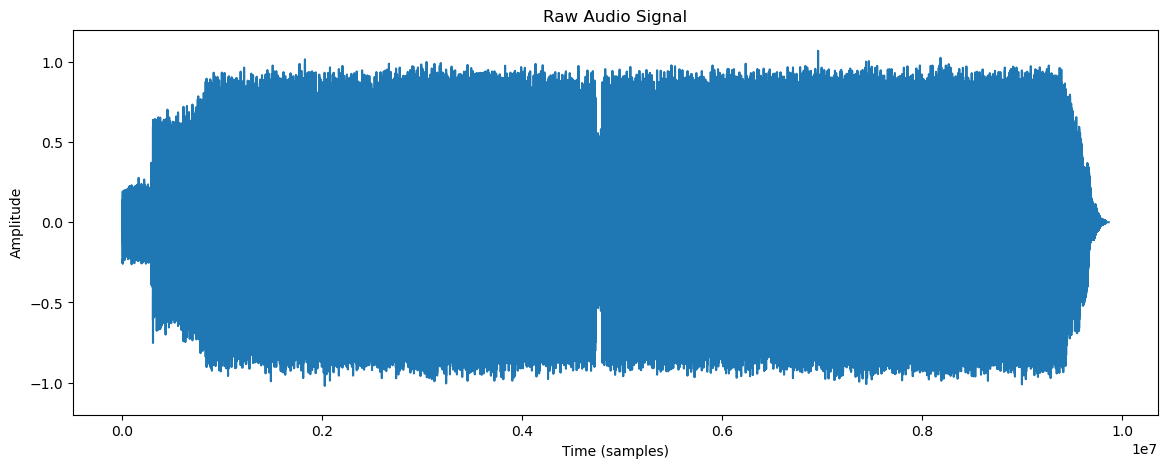

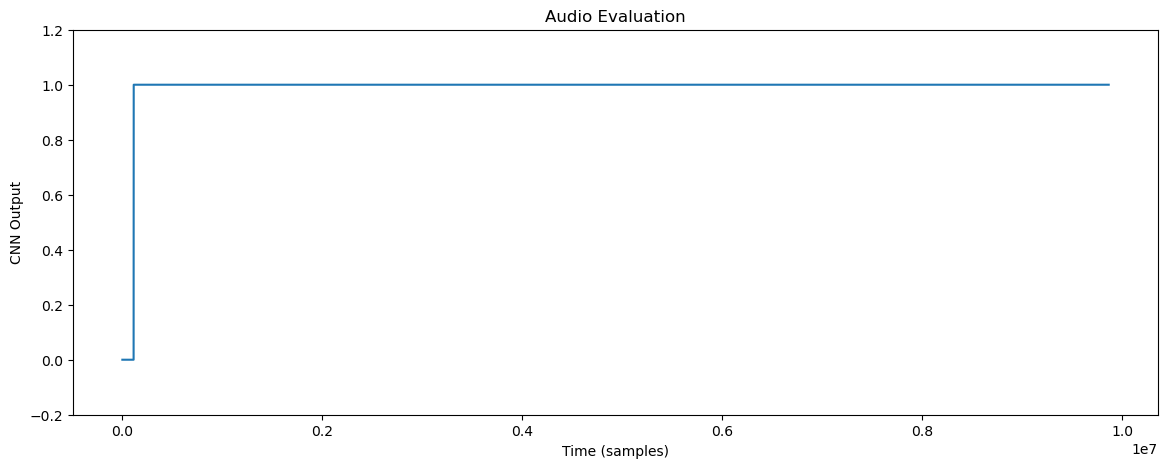

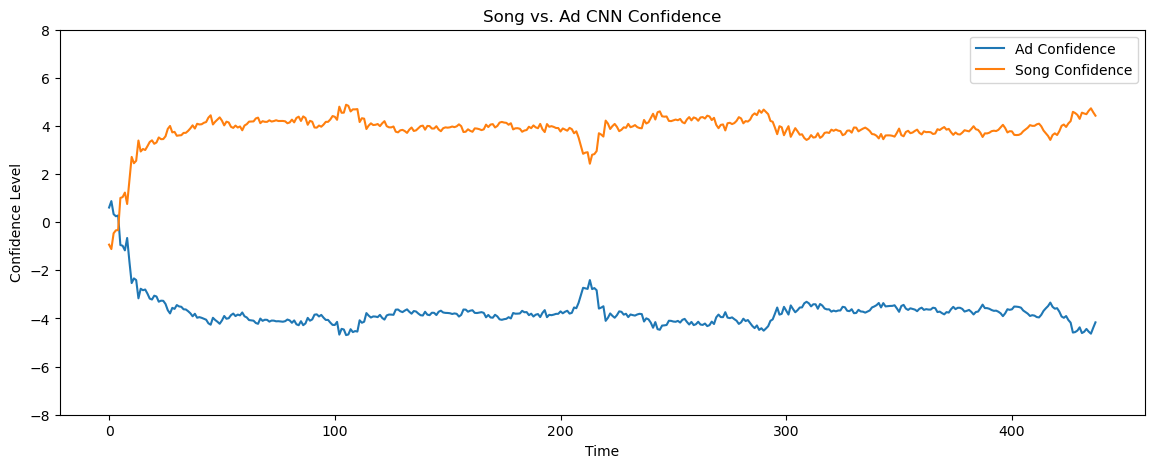

In [10]:
# plot audio (MFCC + delta)
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-1.2, 1.2)
plt.title('Raw Audio Signal')
#plt.savefig(os.path.join("graphics", "mfcc_audio.png"), transparent=True)
plt.show()

# plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc_d)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Audio Evaluation')
#plt.savefig(os.path.join("graphics", "mfcc_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc_d, label='Ad Confidence')
plt.plot(song_confidence_mfcc_d, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-8, 8)
plt.title('Song vs. Ad CNN Confidence')
#plt.savefig(os.path.join("graphics", "mfcc_confidence.png"), transparent=True)
plt.show()

# Evaluate Audio (Raw)
*NOTE: current lack of audio loudness normalization makes raw data not practical. Appears more accurate than it would be in practice.

In [11]:
# evaluate audio (raw)

# update window parameters so it runs in a semi-reasonable amount of non-infinite time
win_div = 1

window_stride = win_length//win_div

window_raw = np.empty((1, 1, win_length))
print(f"tensor shape: {window_raw.shape}")

audio_eval_raw = []
song_confidence_raw = []
ad_confidence_raw = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window_raw[0] = get_window(audio, i, win_length)
    raw_tensor = torch.tensor(window_raw, dtype=torch.float32)
    output = model_raw(raw_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_raw.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_raw.append(output.data[0][0])
    song_confidence_raw.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_raw)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_raw)):
    if(audio_eval_raw[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_raw = temp_eval

tensor shape: (1, 1, 220500)


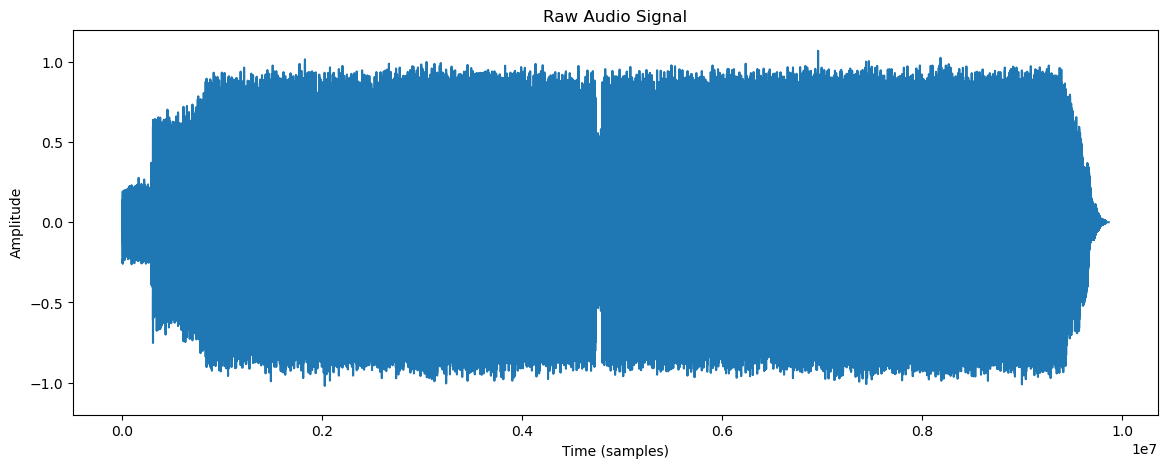

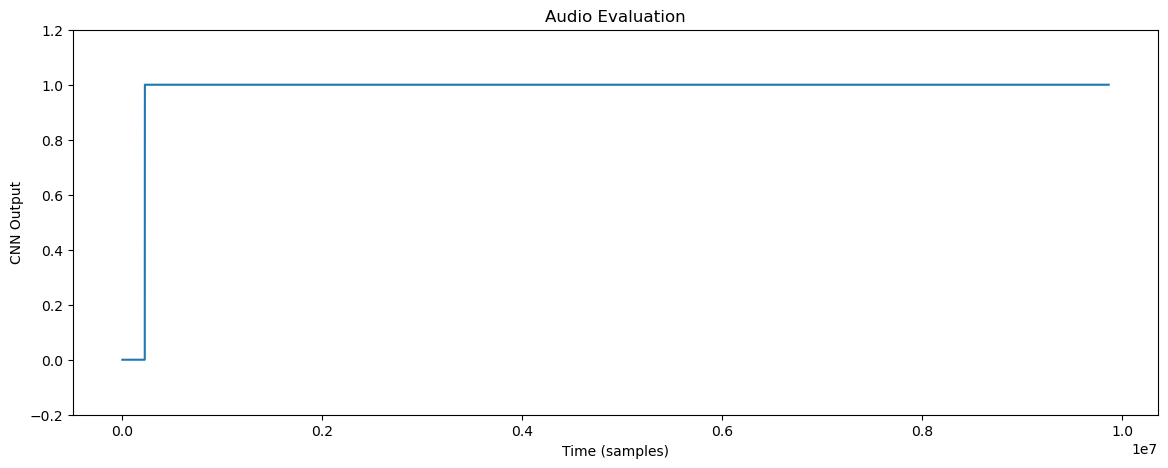

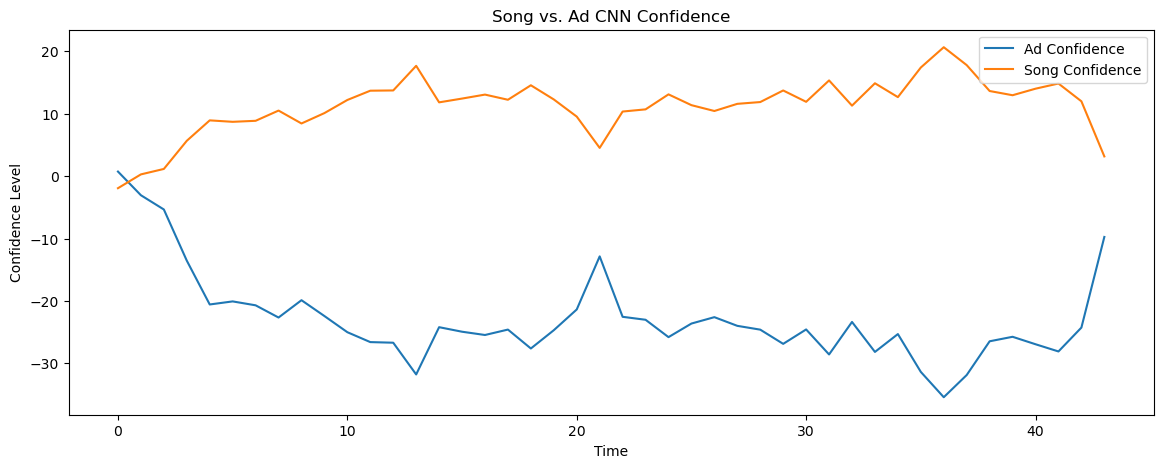

In [12]:
# plot audio (MFCC)
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-1.2, 1.2)
plt.title('Raw Audio Signal')
#plt.savefig(os.path.join("graphics", "mfcc_audio.png"), transparent=True)
plt.show()

# plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_raw)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Audio Evaluation')
#plt.savefig(os.path.join("graphics", "mfcc_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_raw, label='Ad Confidence')
plt.plot(song_confidence_raw, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
#plt.ylim(-8, 8)
plt.title('Song vs. Ad CNN Confidence')
#plt.savefig(os.path.join("graphics", "mfcc_confidence.png"), transparent=True)
plt.show()